In [1]:
#@title required libraries
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 10.0 MB/s eta 0:00:00


In [2]:
#@title download repo
! git clone https://github.com/hdspgroup/SeismicEnhancement
%cd SeismicEnhancement

Cloning into 'SeismicEnhancement'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 190 (delta 79), reused 67 (delta 20), pack-reused 0
Receiving objects: 100% (190/190), 41.00 MiB | 22.98 MiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/SeismicEnhancement


In [3]:
#@title download F3 patches dataset
! gdown 1i1Ih9iVeLx5Bf5vhUuh9N_wNOZ2XB0OW
! mkdir /data
! unzip patches_f3_v4.zip -d /data

Streaming output truncated to the last 5000 lines.
  inflating: /data/patches_f3_v4/patch_3329.npy  
  inflating: /data/patches_f3_v4/patch_333.npy  
  inflating: /data/patches_f3_v4/patch_3330.npy  
  inflating: /data/patches_f3_v4/patch_3331.npy  
  inflating: /data/patches_f3_v4/patch_3332.npy  
  inflating: /data/patches_f3_v4/patch_3333.npy  
  inflating: /data/patches_f3_v4/patch_3334.npy  
  inflating: /data/patches_f3_v4/patch_3335.npy  
  inflating: /data/patches_f3_v4/patch_3336.npy  
  inflating: /data/patches_f3_v4/patch_3337.npy  
  inflating: /data/patches_f3_v4/patch_3338.npy  
  inflating: /data/patches_f3_v4/patch_3339.npy  
  inflating: /data/patches_f3_v4/patch_334.npy  
  inflating: /data/patches_f3_v4/patch_3340.npy  
  inflating: /data/patches_f3_v4/patch_3341.npy  
  inflating: /data/patches_f3_v4/patch_3342.npy  
  inflating: /data/patches_f3_v4/patch_3343.npy  
  inflating: /data/patches_f3_v4/patch_3344.npy  
  inflating: /data/patches_f3_v4/patch_3345.npy  
 

In [4]:
import os
import torch

from dataclasses import dataclass
from torchvision.utils import make_grid

from libs.utils import get_default_device
from libs.dataloader import get_dataloader, inverse_transform
from libs.diffusion.config import BaseConfig, TrainingConfig, ModelConfig

torch.Size([16, 1, 128, 128])


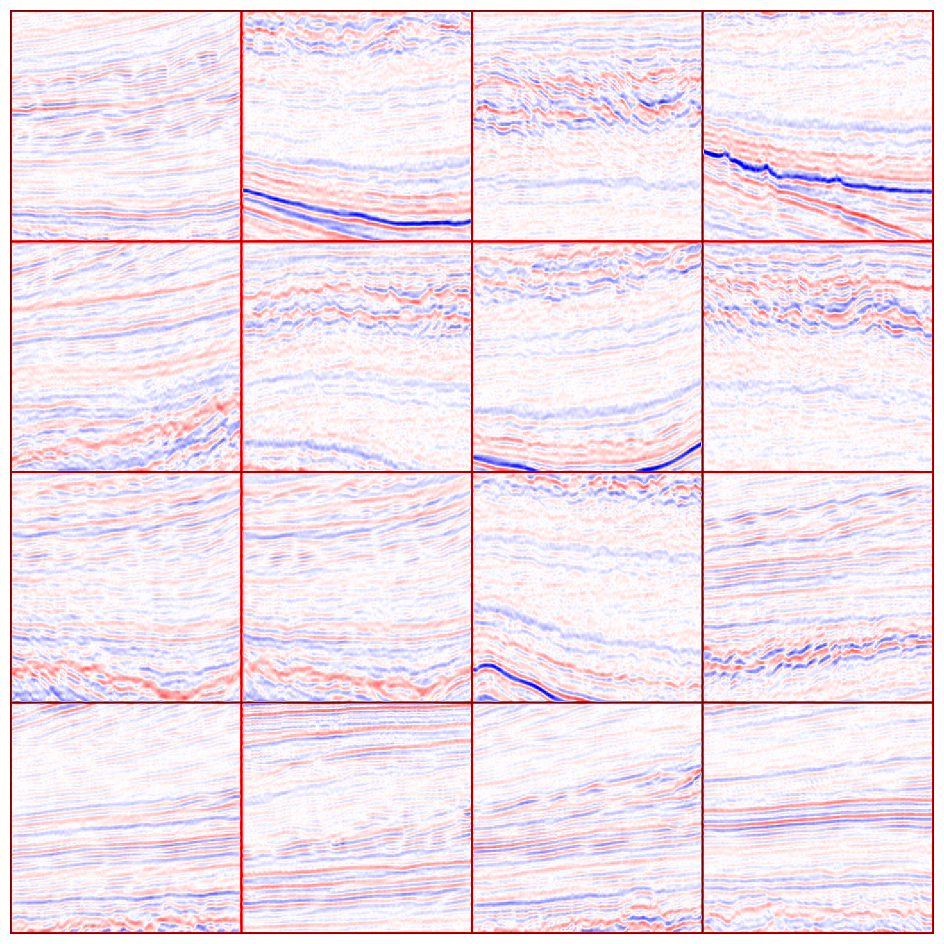

In [5]:
import matplotlib.pyplot as plt

loader = get_dataloader(
    dataset_name=BaseConfig.DATASET,
    batch_size=16,
    device='cpu',
)

plt.figure(figsize=(12, 12), facecolor='white')

for b_image in loader:
    print(b_image.shape)
    b_image = inverse_transform(b_image).cpu()
    grid_img = make_grid(b_image / 255.0, nrow=4, padding=True, pad_value=1, normalize=False)
    plt.imshow(grid_img.permute(1, 2, 0)[..., 0], cmap="seismic", vmin=0, vmax=1)
    plt.axis("off")
    break

In [6]:
from libs.diffusion.ddpm import SimpleDiffusion, forward_diffusion

sd = SimpleDiffusion(num_diffusion_timesteps=TrainingConfig.TIMESTEPS, device="cpu")

loader = iter(  # converting dataloader into an iterator for now.
    get_dataloader(
        dataset_name=BaseConfig.DATASET,
        batch_size=4,
        device="cpu",
    )
)

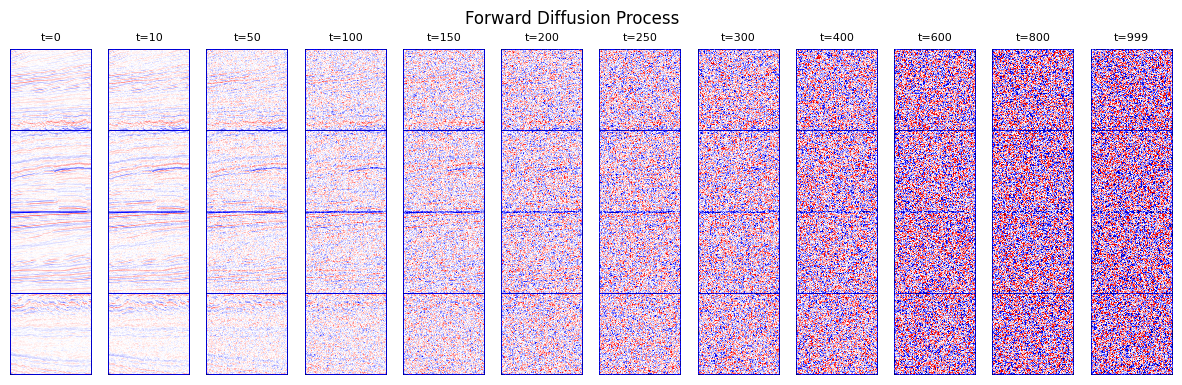

In [7]:
x0s = next(loader)

noisy_images = []
# specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]
for timestep in specific_timesteps:
    timestep = torch.as_tensor(timestep, dtype=torch.long)

    xts, _ = forward_diffusion(sd, x0s, timestep)
    xts    = inverse_transform(xts) / 255.0
    xts    = make_grid(xts, nrow=1, padding=1)

    noisy_images.append(xts)

# Plot and see samples at different timesteps

_, ax = plt.subplots(1, len(noisy_images), figsize=(15, 5), facecolor='white')

for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    ax[i].imshow(noisy_sample.squeeze(0).permute(1, 2, 0)[..., 0], cmap="seismic", vmin=0, vmax=1)
    ax[i].set_title(f"t={timestep}", fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Forward Diffusion Process", y=0.9)
plt.axis("off")
plt.show()

In [8]:
import torch.nn as nn
from libs.diffusion.models import UNet

from torch.cuda import amp

model = UNet(
    input_channels          = TrainingConfig.IMG_SHAPE[0],
    output_channels         = TrainingConfig.IMG_SHAPE[0],
    base_channels           = ModelConfig.BASE_CH,
    base_channels_multiples = ModelConfig.BASE_CH_MULT,
    apply_attention         = ModelConfig.APPLY_ATTENTION,
    dropout_rate            = ModelConfig.DROPOUT_RATE,
    time_multiple           = ModelConfig.TIME_EMB_MULT,
)
model.to(BaseConfig.DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=TrainingConfig.LR)

dataloader = get_dataloader(
    dataset_name  = BaseConfig.DATASET,
    batch_size    = TrainingConfig.BATCH_SIZE,
    device        = BaseConfig.DEVICE,
    pre_load      = True,
    # pin_memory    = False,
    # num_workers   = TrainingConfig.NUM_WORKERS,
)

loss_fn = nn.MSELoss()

sd = SimpleDiffusion(
    num_diffusion_timesteps = TrainingConfig.TIMESTEPS,
    img_shape               = TrainingConfig.IMG_SHAPE,
    device                  = BaseConfig.DEVICE,
)

scaler = amp.GradScaler()

In [9]:
from libs.utils import setup_log_directory

TrainingConfig.NUM_EPOCHS = 9
total_epochs = TrainingConfig.NUM_EPOCHS + 1
log_dir, checkpoint_dir = setup_log_directory(config=BaseConfig())

# log_dir = r"Logs_Checkpoints\Inference\version_1"
# checkpoint_dir = r"Logs_Checkpoints\checkpoints\version_1"

generate_video = False
ext = ".mp4" if generate_video else ".png"

Logging at: Logs_Checkpoints/Inference/version_0
Model Checkpoint at: Logs_Checkpoints/checkpoints/version_0


In [10]:
# uncomment to start training from checkpoint
# checkpoint_path = os.path.join(checkpoint_dir, "ckpt.tar")
# model.load_state_dict(torch.load(checkpoint_path, map_location='cpu')['model'])

In [11]:
import gc

from libs.diffusion.train import train_one_epoch, reverse_diffusion

for epoch in range(1, 10):
    torch.cuda.empty_cache()
    gc.collect()

    # Algorithm 1: Training
    train_one_epoch(model, sd, dataloader, optimizer, scaler, loss_fn, epoch=epoch)

    if epoch % 1 == 0:
        save_path = os.path.join(log_dir, f"{epoch}{ext}")

        # Algorithm 2: Sampling
        reverse_diffusion(model, sd, timesteps=TrainingConfig.TIMESTEPS, num_images=4, generate_video=generate_video,
            save_path=save_path, img_shape=TrainingConfig.IMG_SHAPE, device=BaseConfig.DEVICE,
        )

        # clear_output()
        checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "model": model.state_dict()
        }
        torch.save(checkpoint_dict, os.path.join(checkpoint_dir, "ckpt.tar"))
        del checkpoint_dict

Train :: Epoch: 1/9:  14%|█▍        | 91/633 [00:29<02:56,  3.08it/s, Loss: 0.0312]


KeyboardInterrupt: ignored

In [12]:
model.to(BaseConfig.DEVICE)

sd = SimpleDiffusion(
    num_diffusion_timesteps = TrainingConfig.TIMESTEPS,
    img_shape               = TrainingConfig.IMG_SHAPE,
    device                  = BaseConfig.DEVICE,
)

log_dir = "inference_results"
os.makedirs(log_dir, exist_ok=True)

Sampling :: 100%|██████████| 999/999 [00:43<00:00, 22.83it/s]


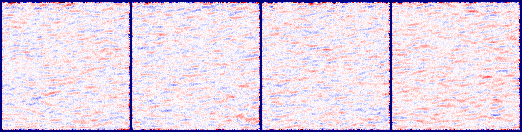

inference_results/20231029-201336.mp4


In [13]:
from datetime import datetime

generate_video = True

ext = ".mp4" if generate_video else ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)

reverse_diffusion(
    model,
    sd,
    num_images=4,
    generate_video=generate_video,
    save_path=save_path,
    timesteps=1000,
    #img_shape=TrainingConfig.IMG_SHAPE,
    img_shape=(1, 128, 128),
    device=BaseConfig.DEVICE,
    nrow=4,
)
print(save_path)